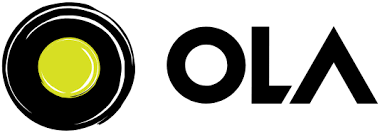

## Problem Statement:
Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Chrun among drivers is high and it's very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don't have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

You are working as a data scientist with the Analytics Department of Ola, focused on driver attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like
- Demographics (city, age, gender etc.)
- Tenure information (joining date, Last Date)
- Historical data regarding the performance of the driver( Quarterly rating, Monthly business acquired, grade, Income)

## Importing Libraries

In [253]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import roc_auc_score,accuracy_score,roc_curve
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

## Reading the data

In [254]:
df = pd.read_csv('ola_driver_scaler.csv')
#Dropping the Unnamed : 0 column.
df = df.drop(columns = 'Unnamed: 0')
df.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


## About the dataset
- MMMM-YY : Reporting Date (Monthly)
- Driver_ID: Unique id for drivers
- Age : Age of the drivers
- Gender : Gender of the driver
    - Male : 0
    - Female : 1
- City: City code of the driver
- Education_Level : Education level
    - 0 : for 10 +
    - 1 : for 12 +
    - 2 : for graduate
- Income : Monthly average Income of the driver
- Date of Joining : Joining date for the driver
- LastWorkingDate : Last date of working for the driver
- Joining Designation : Designation of the driver at the time of joining.
- Grade : Grade of the driver at the time of reporting.
- Total Business Value : The total buisness value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
- Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


In [256]:
df.shape

(19104, 13)

The dataset has 19104 rows and 13 columns.

## Converting MMM-YY , Dateofjoining, LastWorkingDate into Date time format

In [257]:
df['MMM-YY'] = pd.to_datetime(df['MMM-YY'])
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'])

In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19043 non-null  float64       
 3   Gender                19052 non-null  float64       
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  int64         
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  int64         
 10  Grade                 19104 non-null  int64         
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
dtypes: datetime64[ns

## Feature Engineering

#### Sorting the whole dataset based on Reporting Date

In [259]:
df = df.sort_values(by = ['MMM-YY'])

## Aggregating the dataset

In [260]:
df = df.groupby(['Driver_ID']).aggregate({
    'MMM-YY': 'unique',
    'Age':'first',
    'Gender':'last',
    'City':'last',
    'Education_Level':'first',
    'Income':'unique',
    'Dateofjoining': 'first',
    'LastWorkingDate': 'last',
    'Joining Designation': 'last',
    'Grade':'median',
    'Total Business Value':'sum',
    'Quarterly Rating':'unique',
}).reset_index()
df

,Driver_ID,MMM-YY,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,1,"[2019-01-01T00:00:00.000000000, 2019-02-01T00:...",28.0,0.0,C23,2,[57387],2018-12-24,2019-03-11,1,1.0,1715580,[2]
1,2,"[2020-11-01T00:00:00.000000000, 2020-12-01T00:...",31.0,0.0,C7,2,[67016],2020-11-06,NaT,2,2.0,0,[1]
2,4,"[2019-12-01T00:00:00.000000000, 2020-01-01T00:...",43.0,0.0,C13,2,[65603],2019-12-07,2020-04-27,2,2.0,350000,[1]
3,5,"[2019-01-01T00:00:00.000000000, 2019-02-01T00:...",29.0,0.0,C9,0,[46368],2019-01-09,2019-03-07,1,1.0,120360,[1]
4,6,"[2020-08-01T00:00:00.000000000, 2020-09-01T00:...",31.0,1.0,C11,1,[78728],2020-07-31,NaT,3,3.0,1265000,"[1, 2]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,"[2019-01-01T00:00:00.000000000, 2019-02-01T00:...",33.0,0.0,C24,0,[82815],2015-10-15,NaT,2,3.0,21748820,"[3, 1, 4]"
2377,2785,"[2020-08-01T00:00:00.000000000, 2020-09-01T00:...",34.0,1.0,C9,0,[12105],2020-08-28,2020-10-28,1,1.0,0,[1]
2378,2786,"[2019-01-01T00:00:00.000000000, 2019-02-01T00:...",44.0,0.0,C19,0,[35370],2018-07-31,2019-09-22,2,2.0,2815090,"[2, 1]"
2379,2787,"[2019-01-01T00:00:00.000000000, 2019-02-01T00:...",28.0,1.0,C20,2,[69498],2018-07-21,2019-06-20,1,1.0,977830,"[2, 1]"


#### Creating a feature indicating the increase in monthly income.

In [261]:
def get_change_indication(x):
    if len(x)>1:
        if x[0]<x[-1]:
            return 1
        else:
            return 0
    else:
        return 0

In [262]:
df['Change_income'] = df['Income'].apply(get_change_indication)

#### Creating a feature indicating the increase in quarterly rating.

In [263]:
df['Change_rating'] = df['Quarterly Rating'].apply(get_change_indication)

#### Creating the target feature based on the presence of last working day.

In [264]:
df['target'] = 0
df.loc[df['LastWorkingDate'].isna()==False,'target'] = 1

#### Creating two new columns form the reporting date 
- First reporting date and last reporting date

In [265]:
df['first_reporting_date'] = df['MMM-YY'].apply(lambda x: x[0])
df['last_reporting_date'] = df['MMM-YY'].apply(lambda x: x[-1])
df = df.drop(columns = ['MMM-YY'])

In [266]:
df['Income'] = df['Income'].apply(lambda x: np.mean(x))
df['Quarterly Rating'] = df['Quarterly Rating'].apply(lambda x: np.median(x))

In [267]:
df

,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Change_income,Change_rating,target,first_reporting_date,last_reporting_date
0,1,28.0,0.0,C23,2,57387.0,2018-12-24,2019-03-11,1,1.0,1715580,2.0,0,0,1,2019-01-01,2019-03-01
1,2,31.0,0.0,C7,2,67016.0,2020-11-06,NaT,2,2.0,0,1.0,0,0,0,2020-11-01,2020-12-01
2,4,43.0,0.0,C13,2,65603.0,2019-12-07,2020-04-27,2,2.0,350000,1.0,0,0,1,2019-12-01,2020-04-01
3,5,29.0,0.0,C9,0,46368.0,2019-01-09,2019-03-07,1,1.0,120360,1.0,0,0,1,2019-01-01,2019-03-01
4,6,31.0,1.0,C11,1,78728.0,2020-07-31,NaT,3,3.0,1265000,1.5,0,1,0,2020-08-01,2020-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,33.0,0.0,C24,0,82815.0,2015-10-15,NaT,2,3.0,21748820,3.0,0,1,0,2019-01-01,2020-12-01
2377,2785,34.0,1.0,C9,0,12105.0,2020-08-28,2020-10-28,1,1.0,0,1.0,0,0,1,2020-08-01,2020-10-01
2378,2786,44.0,0.0,C19,0,35370.0,2018-07-31,2019-09-22,2,2.0,2815090,1.5,0,0,1,2019-01-01,2019-09-01
2379,2787,28.0,1.0,C20,2,69498.0,2018-07-21,2019-06-20,1,1.0,977830,1.5,0,0,1,2019-01-01,2019-06-01


## Checking for Missing values

In [268]:
df.isna().sum()

Driver_ID                 0
Age                       0
Gender                    0
City                      0
Education_Level           0
Income                    0
Dateofjoining             0
LastWorkingDate         765
Joining Designation       0
Grade                     0
Total Business Value      0
Quarterly Rating          0
Change_income             0
Change_rating             0
target                    0
first_reporting_date      0
last_reporting_date       0
dtype: int64

## Observation:
- The column with missing values are:
    - LastWorkingDate, Since last working date feature is of date type format, we cannot use KNNImputer.

## Imputing LastWorkingDate feature
- We have observed that last working date is very close to last reporting date, so we replace missing working date with last reporting date.

In [269]:
df.loc[df['LastWorkingDate'].isna(),'LastWorkingDate'] = df['last_reporting_date']

In [270]:
df.isna().sum()

Driver_ID               0
Age                     0
Gender                  0
City                    0
Education_Level         0
Income                  0
Dateofjoining           0
LastWorkingDate         0
Joining Designation     0
Grade                   0
Total Business Value    0
Quarterly Rating        0
Change_income           0
Change_rating           0
target                  0
first_reporting_date    0
last_reporting_date     0
dtype: int64

## Descriptive Analysis of numerical attributes

In [271]:
df.describe()

,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Change_income,Change_rating,target
count,2381.000000,2381.000000,2381.000000,2381.00000,2381.000000,2381.000000,2381.000000,2.381000e+03,2381.000000,2381.000000,2381.000000,2381.000000
mean,1397.559009,33.090718,0.410332,1.00756,59272.610248,1.820244,2.078538,4.586742e+06,1.536959,0.018480,0.248635,0.678706
std,806.161628,5.840686,0.491997,0.81629,28325.327154,0.841433,0.931321,9.127115e+06,0.677597,0.134706,0.432313,0.467071
min,1.000000,21.000000,0.000000,0.00000,10747.000000,1.000000,1.000000,-1.385530e+06,1.000000,0.000000,0.000000,0.000000
25%,695.000000,29.000000,0.000000,0.00000,39104.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000
50%,1400.000000,33.000000,0.000000,1.00000,55285.000000,2.000000,2.000000,8.176800e+05,1.000000,0.000000,0.000000,1.000000
75%,2100.000000,37.000000,1.000000,2.00000,75835.000000,2.000000,3.000000,4.173650e+06,2.000000,0.000000,0.000000,1.000000
max,2788.000000,58.000000,1.000000,2.00000,188418.000000,5.000000,5.000000,9.533106e+07,4.000000,1.000000,1.000000,1.000000


## Descriptive Analysis of categorical features

In [272]:
df.describe(include = 'object')

,City
count,2381
unique,29
top,C20
freq,152


## Observations:
- Mean age of the Drivers is 33.09
- Mean monthly income of the drivers is 59272.61
- Mean total business value is 4586742.0
- Most of the drivers belong to city C20.

In [273]:
print('Attrition rate by Education Level')
print(df.groupby('Education_Level')['target'].mean()*100)

print('\nAttrition rate by Gender')
print(df.groupby('Gender')['target'].mean()*100)

print('\nAttrition rate by Grade')
print(df.groupby('Grade')['target'].mean()*100)

print('\nAttrition rate by Increase in income')
print(df.groupby('Change_income')['target'].mean()*100)

print('\nAttrition rate by Increase in quarterly rating')
print(df.groupby('Change_rating')['target'].mean()*100)

print('\nAttrition rate by joining designation')
print(df.groupby('Joining Designation')['target'].mean()*100)

Attrition rate by Education Level
Education_Level
0    69.132653
1    66.289308
2    68.204489
Name: target, dtype: float64

Attrition rate by Gender
Gender
0.0    67.521368
1.0    68.372569
Name: target, dtype: float64

Attrition rate by Grade
Grade
1.0    79.360852
2.0    69.399538
3.0    55.155483
4.0    53.030303
5.0    57.142857
Name: target, dtype: float64

Attrition rate by Increase in income
Change_income
0    69.020111
1     6.818182
Name: target, dtype: float64

Attrition rate by Increase in quarterly rating
Change_rating
0    76.523197
1    41.722973
Name: target, dtype: float64

Attrition rate by joining designation
Joining Designation
1    73.294347
2    68.711656
3    55.578093
4    61.111111
5    72.727273
Name: target, dtype: float64


## Observations:
- Highest attrition rate according to Education level is for 0 i.e 10+
- Highest attrition rate according to Gender is for Females.
- Highest attrition rate according to Grade is for grade 1.
- Highest attrition rate according to Increase in monthly income is for those whose monthly income has not increased or decreased.
- Highest attrition rate according to Increase in quarterly income is for those drivers whose quarterly rating has not increased or decreased.
- Highest attrition rate according to joining designation is for designation 1.

## Outlier Detection

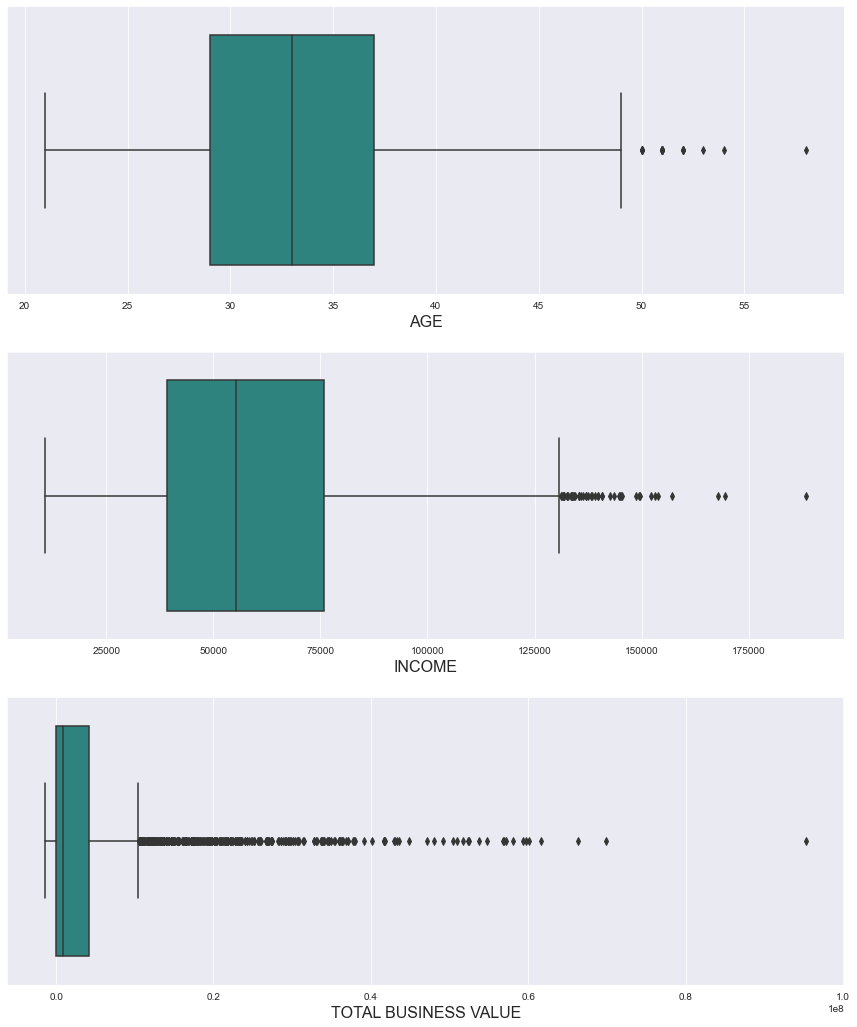

In [274]:
cols = ['Age','Income','Total Business Value']
plt.figure(figsize = (15,18))
sns.set_style('darkgrid')
for i in range(len(cols)):
    plt.subplot(3,1,i+1)
    sns.boxplot(data = df,x = cols[i],palette = 'viridis')
    plt.xlabel(cols[i].upper(),fontsize = 16)
plt.show()

## Observations:
- Features Age, income and total business values all have outliers.

## Univariate Analysis

In [275]:
cols = df.select_dtypes(include = ['int64','float64']).columns
cols

Index(['Driver_ID', 'Age', 'Gender', 'Education_Level', 'Income',
       'Joining Designation', 'Grade', 'Total Business Value',
       'Quarterly Rating', 'Change_income', 'Change_rating', 'target'],
      dtype='object')

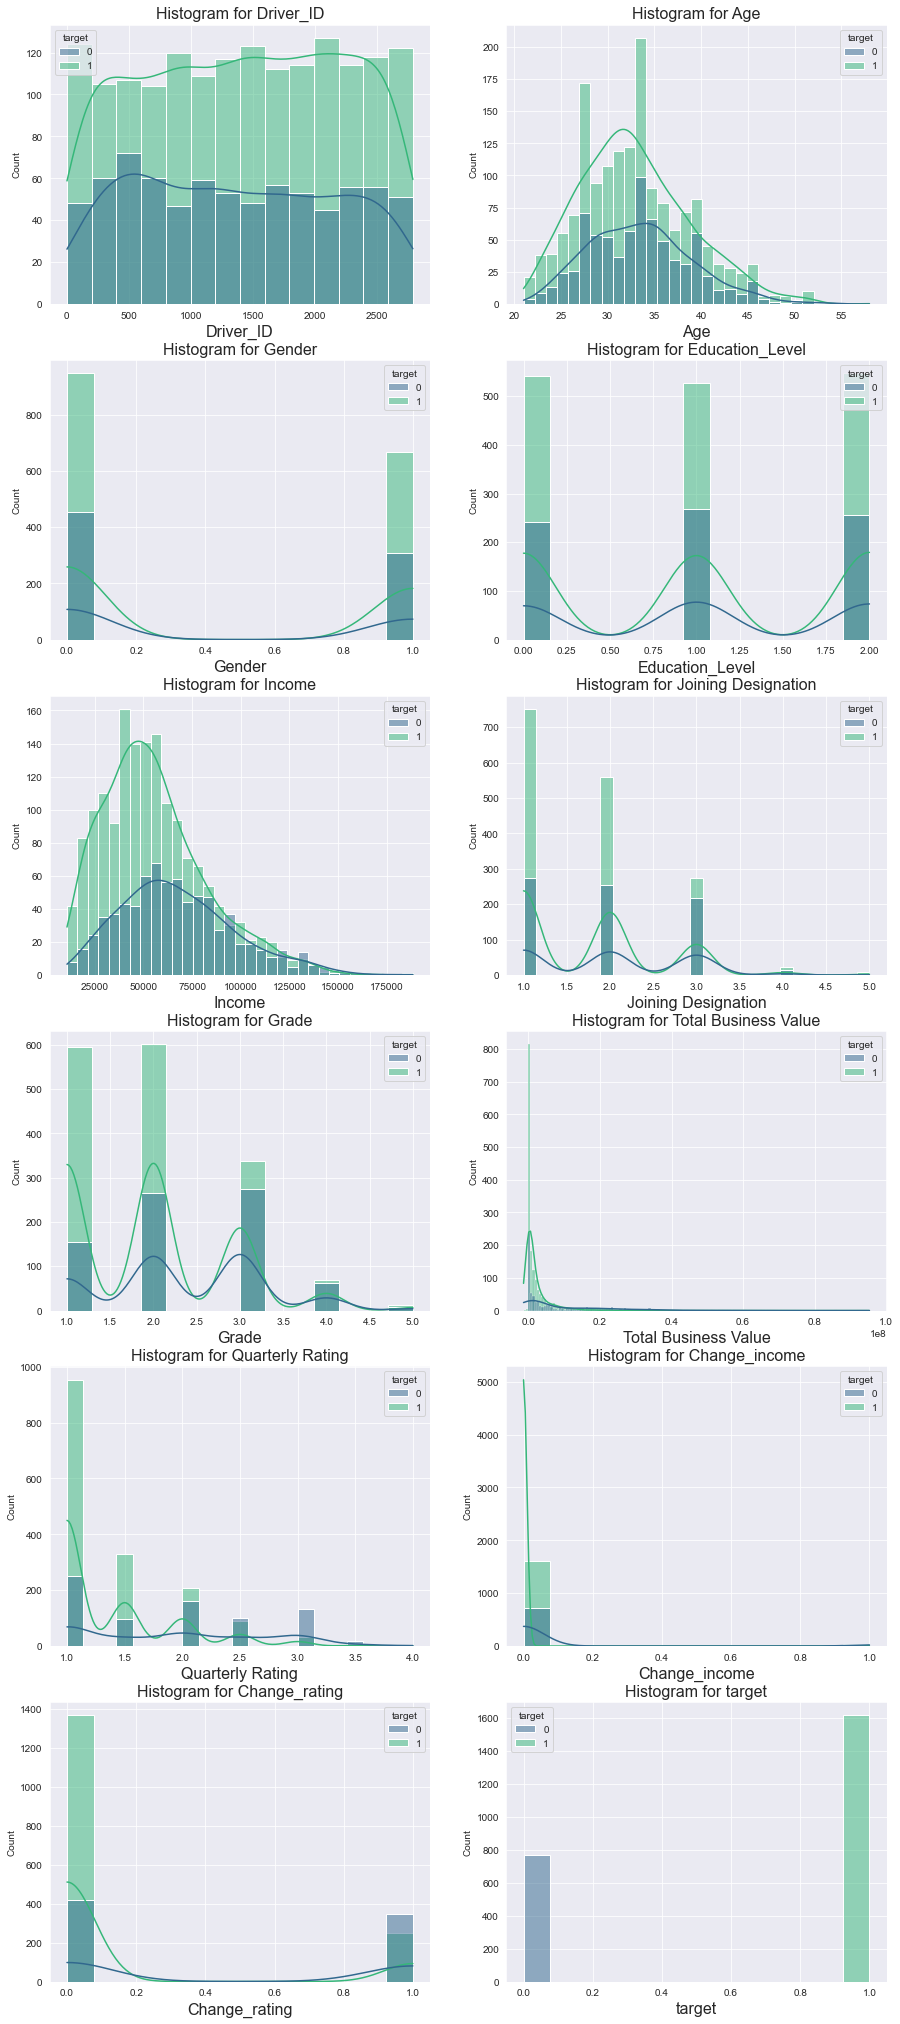

In [276]:
plt.figure(figsize = (15,36))
for i in range(len(cols)//2):
    plt.subplot(6,2,(2*i)+1)
    sns.histplot(data = df,x = cols[2*i],kde = True,
                hue = 'target',palette = 'viridis')
    plt.xlabel(cols[2*i],fontsize = 16)
    plt.title(f"Histogram for {cols[2*i]}",fontsize = 16)
    
    plt.subplot(6,2,(2*i)+2)
    sns.histplot(data = df,x=cols[(2*i)+1],kde = True,
                 hue = 'target',palette = 'viridis')
    plt.xlabel(cols[(2*i)+1],fontsize = 16)
    plt.title(f"Histogram for {cols[(2*i)+1]}",fontsize = 16)
plt.show()

## Observation:
- Age ,Income and Total business value have skewed distributions.

<AxesSubplot:xlabel='City', ylabel='count'>

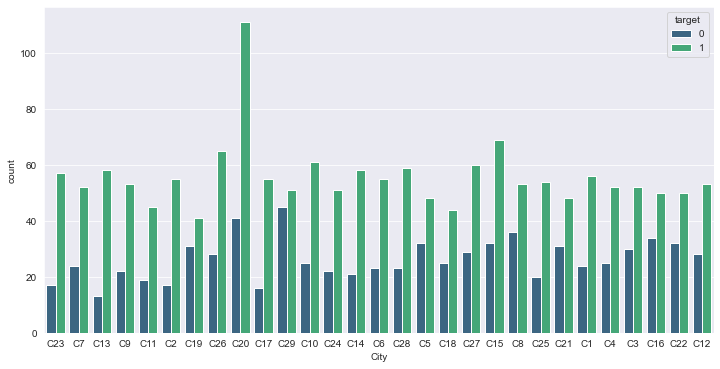

In [277]:
plt.figure(figsize = (12,6))
sns.countplot(data = df, x = 'City',hue = 'target', palette = 'viridis')

## Observations:
- Maximum number of drivers who left belonged to city C20
- Maximum number of drivers who have not left yet are from city C29

In [278]:
df['joining_month'] = df['Dateofjoining'].dt.month
df['joining_year'] = df['Dateofjoining'].dt.year
df['leaving_month'] = df['LastWorkingDate'].dt.month
df['leaving_year'] = df['LastWorkingDate'].dt.year

## Bivariate Analysis

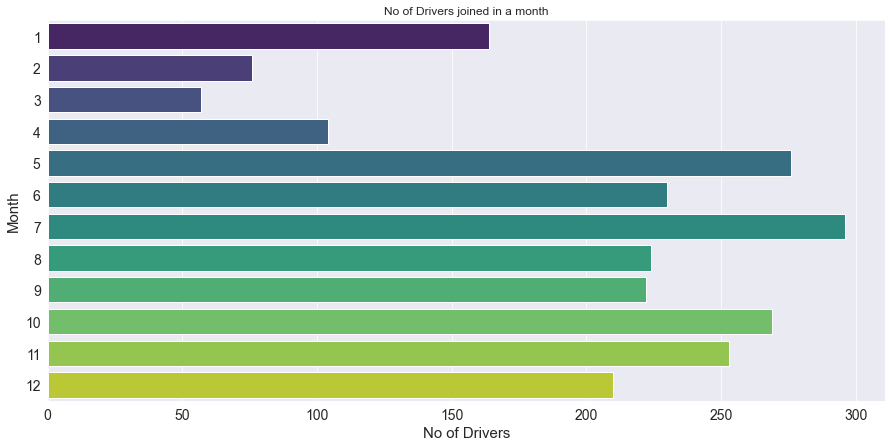

In [279]:
plt.figure(figsize = (15,7))
sns.countplot(data= df,y = 'joining_month',palette = 'viridis')
plt.title("No of Drivers joined in a month")
plt.xlabel('No of Drivers',fontsize = 15)
plt.ylabel('Month',fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

## Observations:
- Highest number of drivers joined in the month of July

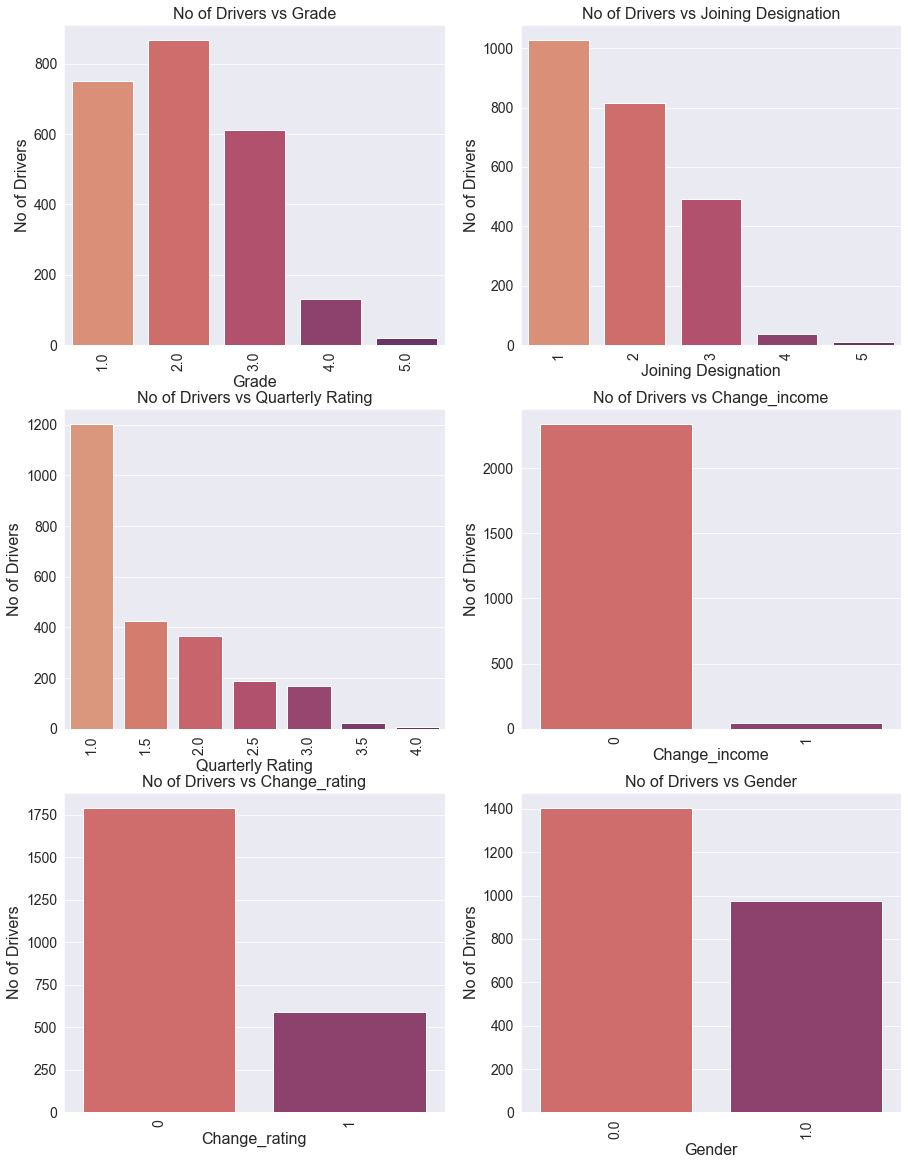

In [280]:
cat = ['Grade','Joining Designation','Quarterly Rating',
       'Change_income','Change_rating','Gender']
plt.figure(figsize = (15,20))
for i in range(len(cat)//2):
    plt.subplot(3,2,(2*i)+1)
    sns.countplot(data = df,x = cat[2*i],palette = 'flare')
    plt.xlabel(cat[2*i],fontsize = 16)
    plt.ylabel('No of Drivers',fontsize = 16)
    plt.title(f"No of Drivers vs {cat[2*i]}",fontsize = 16)
    plt.xticks(fontsize = 14,rotation = 90)
    plt.yticks(fontsize = 14)

    plt.subplot(3,2,(2*i)+2)
    sns.countplot(data = df,x = cat[(2*i)+1],palette = 'flare')
    plt.xlabel(cat[(2*i)+1],fontsize = 16)
    plt.ylabel('No of Drivers',fontsize = 16)
    plt.title(f"No of Drivers vs {cat[(2*i)+1]}",fontsize = 16)
    plt.xticks(fontsize = 14,rotation = 90)
    plt.yticks(fontsize = 14)
plt.show()

## Observations:
- Very few drivers have received an increase in monthly income or increase in quarterly rating.

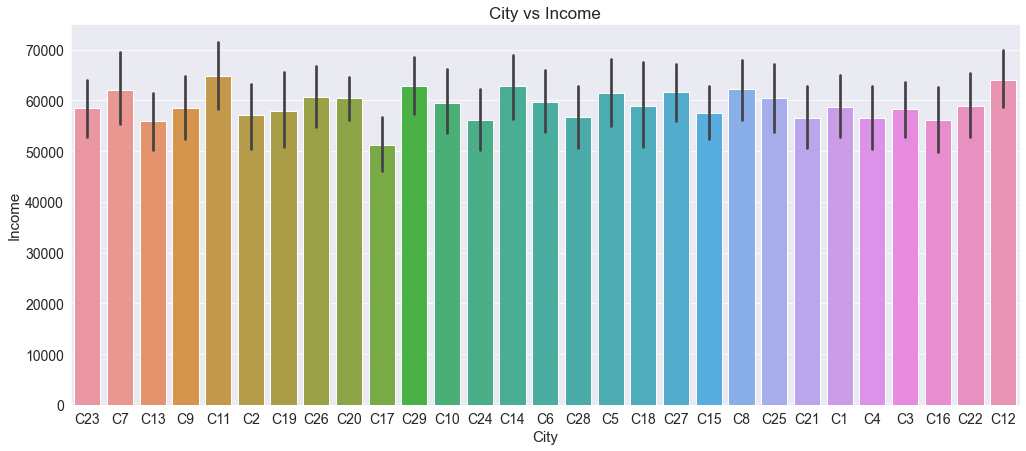

In [281]:
plt.figure(figsize = (17,7))
sns.barplot(data = df,x = 'City',y = 'Income')
plt.title('City vs Income',fontsize = 17)
plt.xlabel('City',fontsize = 15)
plt.ylabel('Income',fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

## Observations:
- Drivers from city C11 had highest average monthly income.
- Drivers from city C17 had lowest average monthly income.

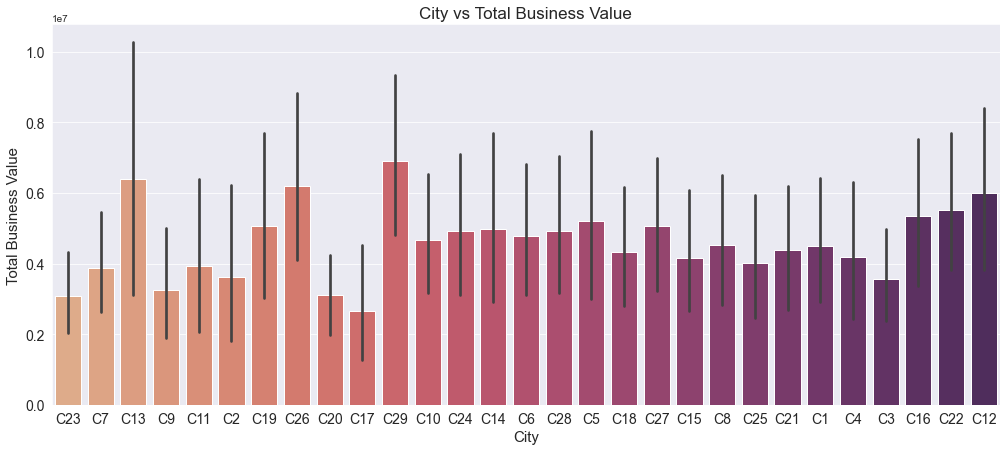

In [282]:
plt.figure(figsize = (17,7))
sns.barplot(data = df,x = 'City',y = 'Total Business Value',
           palette = 'flare')
plt.title('City vs Total Business Value',fontsize = 17)
plt.xlabel('City',fontsize = 15)
plt.ylabel('Total Business Value',fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

## Observations:
- Drivers belonging to city C17 had lowest total business values.
- Drivers belonging to city C29 had highest total business values.

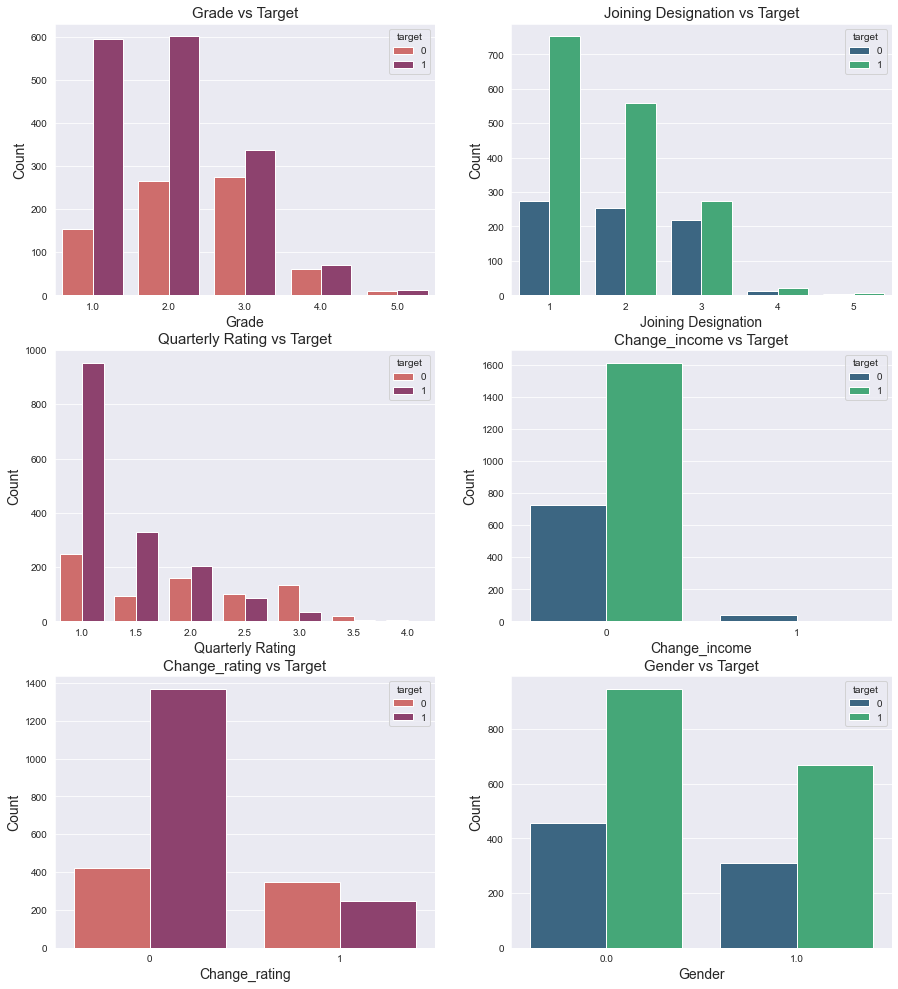

In [283]:
cat = ['Grade','Joining Designation','Quarterly Rating',
       'Change_income','Change_rating','Gender']
plt.figure(figsize = (15,17))
for i in range(len(cat)//2):
    plt.subplot(3,2,(2*i)+1)
    sns.countplot(data = df, x = cat[2*i],
                 hue = 'target',palette = 'flare')
    plt.title(f"{cat[2*i]} vs Target",fontsize = 15)
    plt.xlabel(cat[2*i],fontsize = 14)
    plt.ylabel('Count',fontsize = 14)

    plt.subplot(3,2,(2*i)+2)
    sns.countplot(data = df, x = cat[(2*i)+1],
                  hue = 'target',palette = 'viridis')
    plt.title(f"{cat[(2*i)+1]} vs Target",fontsize = 15)
    plt.xlabel(cat[(2*i)+1],fontsize = 14)
    plt.ylabel('Count',fontsize = 14)
plt.show()

## Observations:
- Most of the drivers who left had a grade 2 or grade 1.
- Most of the drivers who left had Joining Designation of 1 and 2.
- Most of the drivers who left has Quarterly rating of 1.
- Most of the drivers who left had no increase in their monthly income.
- Most of the drivers who left had no increase in their quarterly rating.
- Most of the drivers whoh left were Males.

## Multivariate Analysis

In [284]:
num = ['Age','Income','Total Business Value']
cat = ['Grade','Joining Designation','Quarterly Rating',
       'Change_income','Change_rating','Gender']

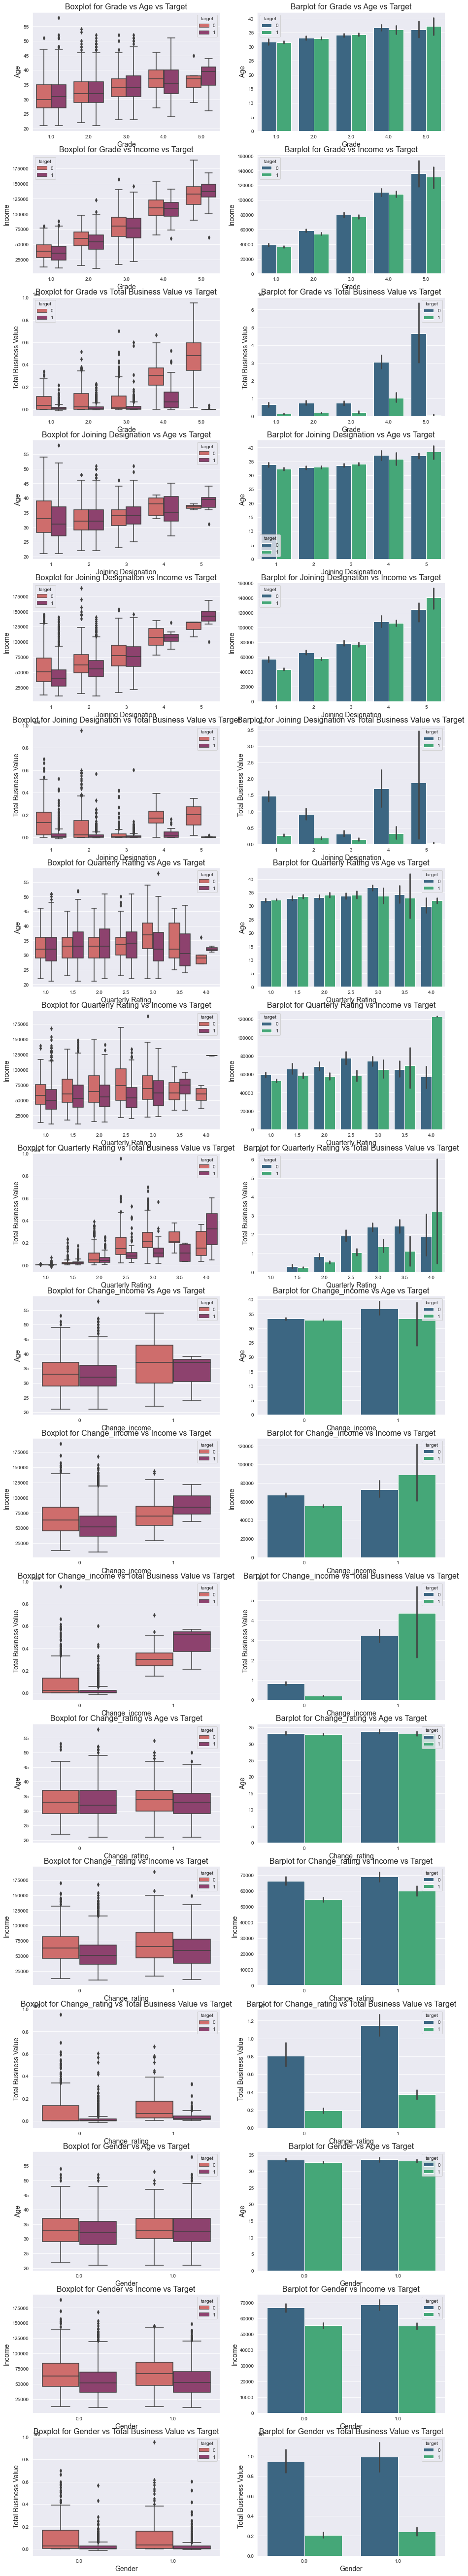

In [285]:
plt.figure(figsize=(15,95))
c = 0
for i in range(len(cat)):
    for j in range(len(num)):
        plt.subplot(18,2,c+1)
        sns.boxplot(data = df, x = cat[i],y = num[j],
                    hue = 'target',palette = 'flare')
        plt.xlabel(f"{cat[i]}",fontsize = 14)
        plt.ylabel(f"{num[j]}",fontsize = 14)
        plt.title(f"Boxplot for {cat[i]} vs {num[j]} vs Target",
                 fontsize = 16)
        
        plt.subplot(18,2,c+2)
        sns.barplot(data = df, x = cat[i],y = num[j],
                    hue = 'target',palette = 'viridis')
        plt.xlabel(f"{cat[i]}",fontsize = 14)
        plt.ylabel(f"{num[j]}",fontsize = 14)
        plt.title(f"Barplot for {cat[i]} vs {num[j]} vs Target",
                 fontsize = 16)
        c+=2
plt.show()

## Observations:
- It is observed that drivers leaving from grades 1,2,3 and 4 had a higher median age as compared to the drivers who didnot leave.
- Drivers leaving from every grade had low total business value compared to drivers who stayed.
- Drivers who left had lower ages compared to those who stayed.
- Drivers who has received positive change in quarterly rating had more income irrespective of whether they stayed or left.
- Driver who had received positive change in quarterly rating also had more total business value.
- Drivers who had received an increase in monthly income had high total business value compared to those drivers who did not receive an increase in the monthly income.

## Correlation

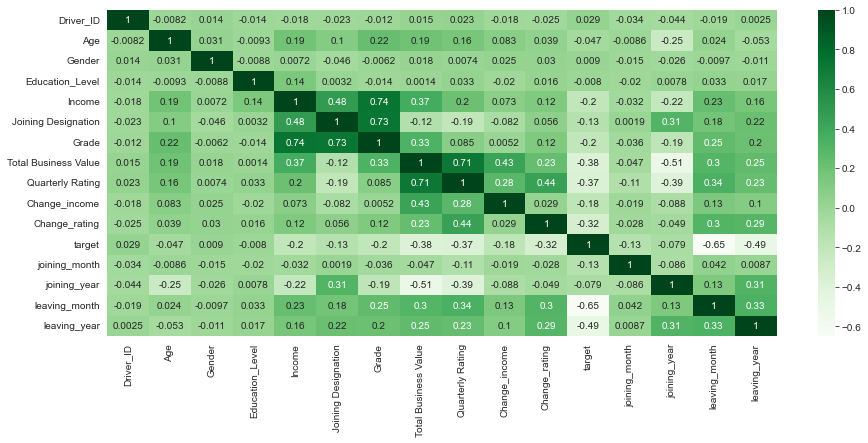

In [286]:
corr = df.corr()
plt.figure(figsize =(15,6))
sns.heatmap(corr,annot = True,cmap = 'Greens')
plt.show()

## Observations:
- There is a strong correlation between Income and Grade.
- There is a strong correlation between Joining Designation and Grade
- There is a strong correlation between Quarterly rating and Total Business value.

## One hot encoding of categorical features

In [287]:
from sklearn.preprocessing import OneHotEncoder

In [288]:
enc = OneHotEncoder()
x=enc.fit_transform(df[['City']])

In [289]:
x.toarray().shape

(2381, 29)

#### We have observed that doing one hot encoding of City featuer will lead to extra 29 columns. So , we will not do One Hot encoding.

## City Encoding

In [290]:
city_mapping = {
    'C1': 1, 'C2': 2, 'C3': 3, 'C4': 4, 'C5': 5, 'C6': 6, 'C7': 7, 'C8': 8, 'C9': 9, 'C10': 10,
    'C11': 11, 'C12': 12, 'C13': 13, 'C14': 14, 'C15': 15, 'C16': 16, 'C17': 17, 'C18': 18, 'C19': 19, 'C20': 20,
    'C21': 21, 'C22': 22, 'C23': 23, 'C24': 24, 'C25': 25, 'C26': 26, 'C27': 27, 'C28': 28, 'C29': 29
}


df['City'] = df['City'].map(city_mapping)

In [291]:
df = df.drop(columns = ['first_reporting_date','last_reporting_date',
                       'joining_month','joining_year','leaving_month',
                       'leaving_year'])

In [292]:
df['LastWorkingDate'] = df['LastWorkingDate'].dt.year
df['Dateofjoining'] = df['Dateofjoining'].dt.year

In [293]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Driver_ID             2381 non-null   int64  
 1   Age                   2381 non-null   float64
 2   Gender                2381 non-null   float64
 3   City                  2381 non-null   int64  
 4   Education_Level       2381 non-null   int64  
 5   Income                2381 non-null   float64
 6   Dateofjoining         2381 non-null   int64  
 7   LastWorkingDate       2381 non-null   int64  
 8   Joining Designation   2381 non-null   int64  
 9   Grade                 2381 non-null   float64
 10  Total Business Value  2381 non-null   int64  
 11  Quarterly Rating      2381 non-null   float64
 12  Change_income         2381 non-null   int64  
 13  Change_rating         2381 non-null   int64  
 14  target                2381 non-null   int64  
dtypes: float64(5), int64(

In [294]:
X = df.drop(columns = ['target'])
y = df['target']

## Standardization

In [295]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cols = X.columns
X = scaler.fit_transform(X)
X = pd.DataFrame(X,columns = cols)
X

,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Change_income,Change_rating
0,-1.732720,-0.871779,-0.834188,0.915693,1.216049,-0.066584,-0.333277,-1.342158,-0.975022,-1.158317,-0.314641,0.683501,-0.137214,-0.575249
1,-1.731479,-0.358033,-0.834188,-0.995877,1.216049,0.273431,0.909531,0.731611,0.213676,-0.084348,-0.502646,-0.792613,-0.137214,-0.575249
2,-1.728998,1.696952,-0.834188,-0.279038,1.216049,0.223536,0.288127,0.731611,0.213676,-0.084348,-0.464290,-0.792613,-0.137214,-0.575249
3,-1.727757,-0.700530,-0.834188,-0.756931,-1.234575,-0.455681,0.288127,-1.342158,-0.975022,-1.158317,-0.489456,-0.792613,-0.137214,-0.575249
4,-1.726516,-0.358033,1.198771,-0.517984,-0.009263,0.686999,0.909531,0.731611,1.402374,0.989621,-0.364019,-0.054556,-0.137214,1.738378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,1.720167,-0.015535,-0.834188,1.035166,-1.234575,0.831317,-2.197490,0.731611,0.213676,0.989621,1.880735,2.159614,-0.137214,1.738378
2377,1.721407,0.155713,1.198771,-0.756931,-1.234575,-1.665560,0.909531,0.731611,-0.975022,-1.158317,-0.502646,-0.792613,-0.137214,-0.575249
2378,1.722648,1.868201,-0.834188,0.437800,-1.234575,-0.844037,-0.333277,-1.342158,0.213676,-0.084348,-0.194149,-0.054556,-0.137214,-0.575249
2379,1.723889,-0.871779,1.198771,0.557274,1.216049,0.361074,-0.333277,-1.342158,-0.975022,-1.158317,-0.395489,-0.054556,-0.137214,-0.575249


## Splitting the data for training and testing.

In [296]:
from sklearn.model_selection import train_test_split, KFold, cross_validate

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)
print('X_train : ',X_train.shape)
print('X_test : ',X_test.shape)
print('y_train : ',y_train.shape)
print('y_test : ',y_test.shape)

X_train :  (1904, 14)
X_test :  (477, 14)
y_train :  (1904,)
y_test :  (477,)


## Class Imbalance Treatment

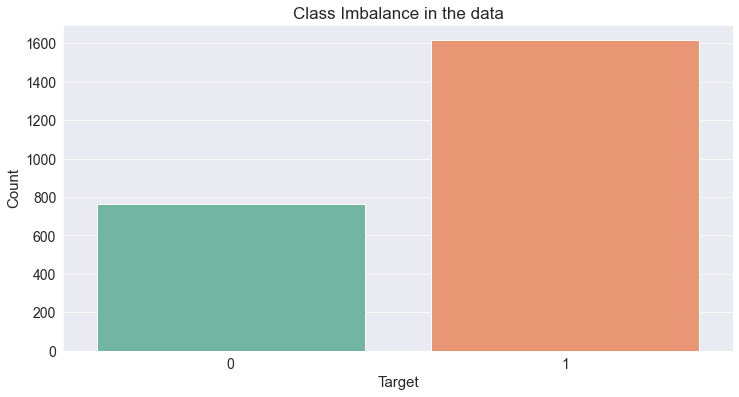

In [297]:
plt.figure(figsize = (12,6))
sns.countplot(data = df, x = 'target',palette = 'Set2')
plt.title('Class Imbalance in the data',fontsize = 17)
plt.xlabel('Target',fontsize = 15)
plt.ylabel('Count',fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [298]:
from imblearn.over_sampling import SMOTE
smot = SMOTE(random_state = 42)
X_train_bal, y_train_bal = smot.fit_resample(X_train,y_train.ravel())

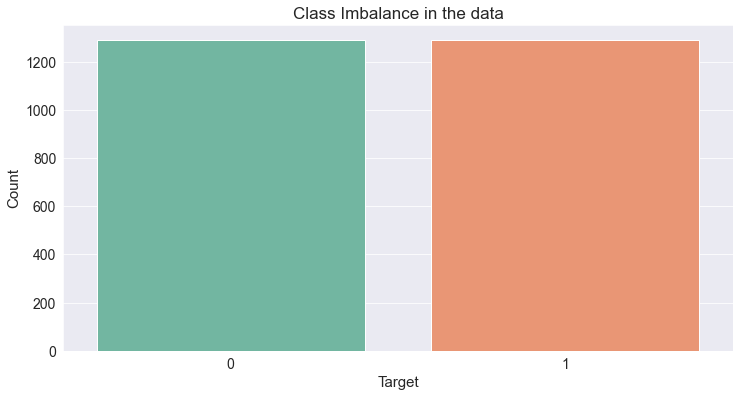

In [299]:
balanced = pd.DataFrame({'target':y_train_bal})
plt.figure(figsize = (12,6))
sns.countplot(data = balanced, x = 'target',palette = 'Set2')
plt.title('Class Imbalance in the data',fontsize = 17)
plt.xlabel('Target',fontsize = 15)
plt.ylabel('Count',fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [300]:
balanced['target'].value_counts()

0    1289
1    1289
Name: target, dtype: int64

## Random Forest Model on Imbalanced Data

In [301]:
rf_clf_i = RandomForestClassifier(random_state = 42, max_depth = 4, n_estimators = 100)
kfold = KFold(n_splits = 10)
cv_acc_results = cross_validate(rf_clf_i,X_train,y_train,
                                cv = kfold,
                                scoring = 'accuracy',
                                return_train_score = True)
print(f"K-Fold Mean Accuracy : \n Train : {cv_acc_results['train_score'].mean()*100:.2f} \n Validation : {cv_acc_results['test_score'].mean()*100:.2f}")


K-Fold Mean Accuracy : 
 Train : 82.32 
 Validation : 80.46


In [302]:
n = np.arange(10)

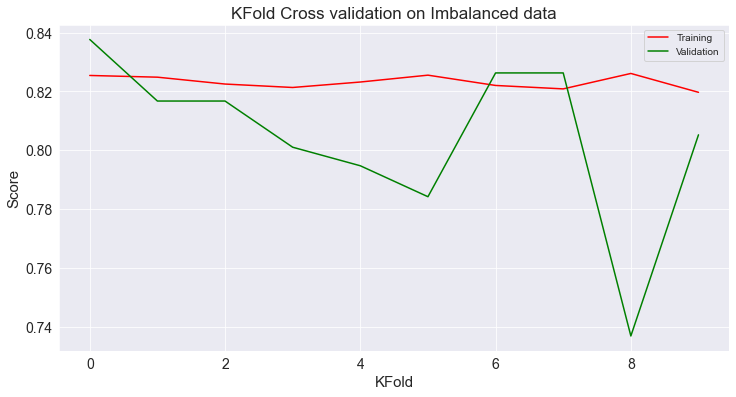

In [303]:
plt.figure(figsize = (12,6))
plt.plot(n,cv_acc_results['train_score'],
         label = 'Training',color = 'r')
plt.plot(n,cv_acc_results['test_score'],
         label = 'Validation',color = 'g')
plt.title('KFold Cross validation on Imbalanced data',fontsize = 17)
plt.legend()
plt.xlabel('KFold',fontsize = 15)
plt.ylabel('Score',fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

## Random Forest Model on Balanced Data

In [304]:
rf_clf_b = RandomForestClassifier(random_state = 42, max_depth = 4, n_estimators = 100)
kfold = KFold(n_splits = 10)
cv_acc_results_b = cross_validate(rf_clf_b,X_train_bal,y_train_bal,
                                cv = kfold,
                                scoring = 'accuracy',
                                return_train_score = True)
print(f"K-Fold Mean Accuracy : \n Train : {cv_acc_results_b['train_score'].mean()*100:.2f} \n Validation : {cv_acc_results_b['test_score'].mean()*100:.2f}")


K-Fold Mean Accuracy : 
 Train : 85.14 
 Validation : 82.82


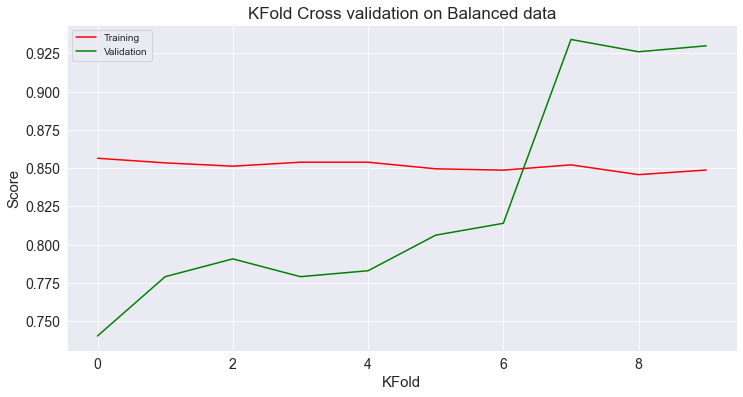

In [305]:
plt.figure(figsize = (12,6))
plt.plot(n,cv_acc_results_b['train_score'],
         label = 'Training',color = 'r')
plt.plot(n,cv_acc_results_b['test_score'],
         label = 'Validation',color = 'g')
plt.title('KFold Cross validation on Balanced data',fontsize = 17)
plt.legend()
plt.xlabel('KFold',fontsize = 15)
plt.ylabel('Score',fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

## Hyperparameter Training for the Random Forest Model

In [306]:
params = {
    'n_estimators':[50,100,200,300,400],
    'max_depth':[3,4,5,7],
    'criterion' : ['gini','entropy'],
    'bootstrap' : [True,False]
}

In [307]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
                    estimator = RandomForestClassifier(random_state = 42),
                   param_grid = params,
                   scoring = 'accuracy',
                   cv = 3,
                   n_jobs = -1
                   )
grid.fit(X_train_bal,y_train_bal)
print('Best params : ',grid.best_params_)
print('Best score : ',grid.best_score_)

Best params :  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 7, 'n_estimators': 50}
Best score :  0.8553252835909793


#### We got our hyperparameters, now we create a Random forest model with the best hyperparameters for both balanced and inbalanced data.

In [308]:
#On imbalanced data
rf_best_clf_i = grid.best_estimator_
rf_best_clf_i.fit(X_train,y_train)

RandomForestClassifier(max_depth=7, n_estimators=50, random_state=42)

Train data score :  0.8870798319327731
Test data score :  0.80083857442348
ROC-AUC score of test dataset :  0.8860754332313966
-----------------------------------------------------------------


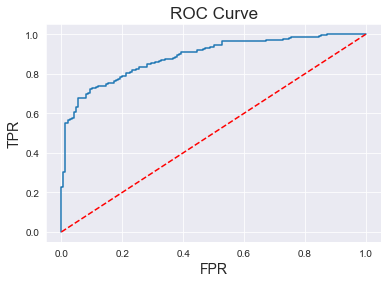

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.64      0.67       150
           1       0.84      0.87      0.86       327

    accuracy                           0.80       477
   macro avg       0.77      0.76      0.76       477
weighted avg       0.80      0.80      0.80       477

Confusion Matrix


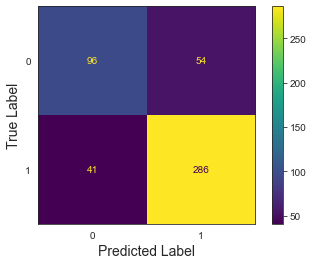

In [309]:
y_pred = rf_best_clf_i.predict(X_test)
proba = rf_best_clf_i.predict_proba(X_test)[:,1]
print("Train data score : ",rf_best_clf_i.score(X_train,y_train))
print("Test data score : ",rf_best_clf_i.score(X_test,y_test))
print('ROC-AUC score of test dataset : ',roc_auc_score(y_test,proba))

print('-'*65)
fpr,tpr,thr = roc_curve(y_test,proba)
plt.plot(fpr,tpr)
plt.plot(fpr,fpr,'--',color = 'red')
plt.title('ROC Curve',fontsize = 17)
plt.xlabel('FPR',fontsize = 14)
plt.ylabel('TPR',fontsize = 14)
plt.show()
print('-'*65)

print(classification_report(y_test,y_pred))
cm_rf_i = confusion_matrix(y_test,y_pred)
print('Confusion Matrix')
sns.set_style('white')
disp = ConfusionMatrixDisplay(confusion_matrix = cm_rf_i,
                             display_labels = rf_best_clf_i.classes_)
disp.plot()
plt.xlabel('Predicted Label',fontsize = 14)
plt.ylabel('True Label',fontsize = 14)
plt.show()

In [310]:
#On balanced data
rf_best_clf_b = grid.best_estimator_
rf_best_clf_b.fit(X_train_bal,y_train_bal)

RandomForestClassifier(max_depth=7, n_estimators=50, random_state=42)

Train data score :  0.8387605042016807
Test data score :  0.790356394129979
ROC-AUC score of test dataset :  0.8876962283384302
-----------------------------------------------------------------


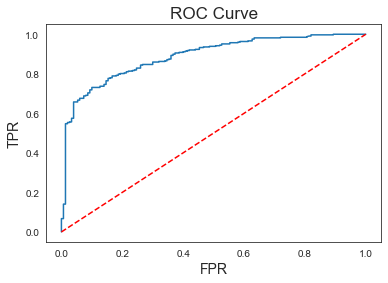

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.85      0.72       150
           1       0.92      0.76      0.83       327

    accuracy                           0.79       477
   macro avg       0.77      0.81      0.78       477
weighted avg       0.83      0.79      0.80       477

Confusion Matrix


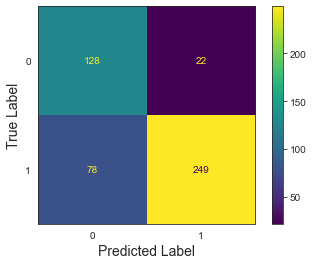

In [311]:
y_pred = rf_best_clf_b.predict(X_test)
proba = rf_best_clf_b.predict_proba(X_test)[:,1]
print("Train data score : ",rf_best_clf_b.score(X_train,y_train))
print("Test data score : ",rf_best_clf_b.score(X_test,y_test))
print('ROC-AUC score of test dataset : ',roc_auc_score(y_test,proba))
print('-'*65)
fpr,tpr,thr = roc_curve(y_test,proba)
plt.plot(fpr,tpr)
plt.plot(fpr,fpr,'--',color = 'red')
plt.title('ROC Curve',fontsize = 17)
plt.xlabel('FPR',fontsize = 14)
plt.ylabel('TPR',fontsize = 14)
plt.show()
print('-'*65)
print(classification_report(y_test,y_pred))
cm_rf_b = confusion_matrix(y_test,y_pred)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix = cm_rf_b,
                             display_labels = rf_best_clf_b.classes_)
disp.plot()
plt.xlabel('Predicted Label',fontsize = 14)
plt.ylabel('True Label',fontsize = 14)
plt.show()

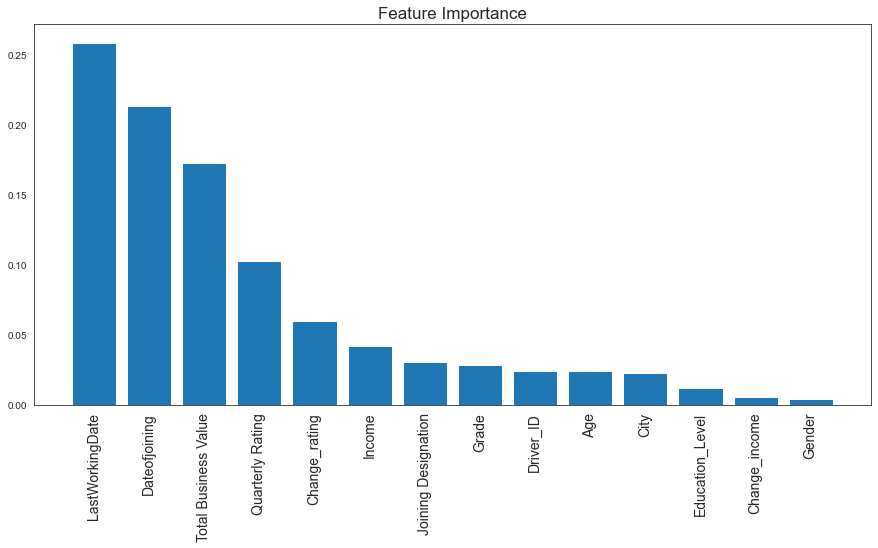

In [312]:
importances = rf_best_clf_b.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X.columns[i] for i in indices]
plt.figure(figsize = (15,7))
plt.title("Feature Importance",fontsize = 17)
plt.bar(range(X.shape[1]),importances[indices])
plt.xticks(range(X.shape[1]),names,rotation = 90,fontsize = 14)
plt.show()

## Hyperparameter Training for GBDT Model on Balanced Data

In [313]:
params = {
    'n_estimators':[50,100,150,200,400],
    'max_depth':[3,4,5,7],
    'max_leaf_nodes':[20,40,80],
    'learning_rate':[0.1,0.2,0.3]
}

In [314]:
grid = GridSearchCV(
                    estimator = GBC(random_state = 42),
                   param_grid = params,
                   scoring = 'accuracy',
                   cv = 3,
                   n_jobs = -1
                   )
grid.fit(X_train,y_train)
print('Best params : ',grid.best_params_)
print('Best score : ',grid.best_score_)

Best params :  {'learning_rate': 0.1, 'max_depth': 7, 'max_leaf_nodes': 20, 'n_estimators': 50}
Best score :  0.8287827980492976


#### We got our hyperparameters, now we create a GBDT model with the best hyperparameters for both balanced data.

In [315]:
gbc_b = grid.best_estimator_
gbc_b.fit(X_train_bal,y_train_bal)

GradientBoostingClassifier(max_depth=7, max_leaf_nodes=20, n_estimators=50,
                           random_state=42)

Train data score :  0.9387121799844841
Test data score :  0.8029350104821803
ROC-AUC score of test dataset :  0.8885423037716615
-----------------------------------------------------------------


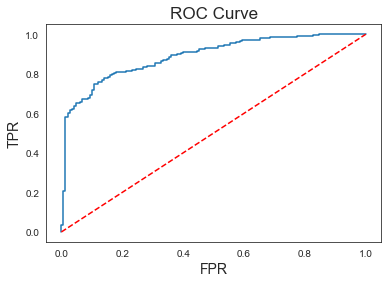

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.78      0.71       150
           1       0.89      0.81      0.85       327

    accuracy                           0.80       477
   macro avg       0.77      0.80      0.78       477
weighted avg       0.82      0.80      0.81       477

Confusion Matrix


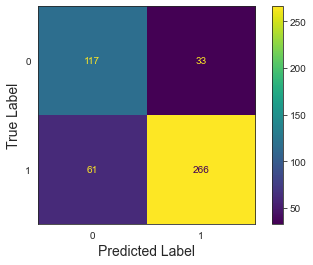

In [316]:
y_pred = gbc_b.predict(X_test)
proba = gbc_b.predict_proba(X_test)[:,1]
print("Train data score : ",gbc_b.score(X_train_bal,y_train_bal))
print("Test data score : ",gbc_b.score(X_test,y_test))
print('ROC-AUC score of test dataset : ',roc_auc_score(y_test,proba))

print('-'*65)
fpr,tpr,thr = roc_curve(y_test,proba)
plt.plot(fpr,tpr)
plt.plot(fpr,fpr,'--',color = 'red')
plt.title('ROC Curve',fontsize = 17)
plt.xlabel('FPR',fontsize = 14)
plt.ylabel('TPR',fontsize = 14)
plt.show()
print('-'*65)

print(classification_report(y_test,y_pred))
cm_gbc_b = confusion_matrix(y_test,y_pred)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix = cm_gbc_b,
                             display_labels = gbc_b.classes_)
disp.plot()
plt.xlabel('Predicted Label',fontsize = 14)
plt.ylabel('True Label',fontsize = 14)
plt.show()

## Hyperparameter Tuning for XGBClassifier

In [317]:
params = {
    'n_estimators':[50,100,150,200],
    'max_depth':[3,4,5,7],
    'learning_rate':[0.1,0.2,0.3],
    'subsample':[0.6,0.8,1.0],
    'colsample_bytree':[0.6,0.8,1.0]
}

In [318]:
random_search = RandomizedSearchCV(XGBClassifier(random_state = 42),
                                  param_distributions = params,
                                  n_iter = 10,
                                  scoring = 'accuracy',
                                  n_jobs = -1,
                                  cv = 3,
                                  verbose = 2)
random_search.fit(X_train_bal,y_train_bal)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5, 7],
                                        'n_estimators': [50, 100, 150, 200],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='accuracy', verbose=2)

In [319]:
random_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [320]:
xgb_b = random_search.best_estimator_
xgb_b.fit(X_train_bal,y_train_bal)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Train data score :  0.9996121024049651
Test data score :  0.8050314465408805
ROC-AUC score of test dataset :  0.876289500509684
-----------------------------------------------------------------


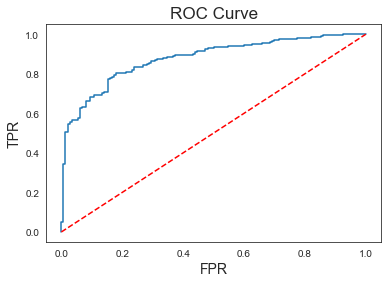

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       150
           1       0.87      0.84      0.85       327

    accuracy                           0.81       477
   macro avg       0.77      0.79      0.78       477
weighted avg       0.81      0.81      0.81       477

Confusion Matrix


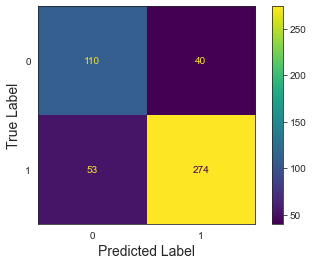

In [321]:
y_pred = xgb_b.predict(X_test)
proba = xgb_b.predict_proba(X_test)[:,1]
print("Train data score : ",xgb_b.score(X_train_bal,y_train_bal))
print("Test data score : ",xgb_b.score(X_test,y_test))
print('ROC-AUC score of test dataset : ',roc_auc_score(y_test,proba))

print('-'*65)
fpr,tpr,thr = roc_curve(y_test,proba)
plt.plot(fpr,tpr)
plt.plot(fpr,fpr,'--',color = 'red')
plt.title('ROC Curve',fontsize = 17)
plt.xlabel('FPR',fontsize = 14)
plt.ylabel('TPR',fontsize = 14)
plt.show()
print('-'*65)

print(classification_report(y_test,y_pred))
cm_xgb_b = confusion_matrix(y_test,y_pred)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix = cm_xgb_b,
                             display_labels = xgb_b.classes_)
disp.plot()
plt.xlabel('Predicted Label',fontsize = 14)
plt.ylabel('True Label',fontsize = 14)
plt.show()

## Performance Metric

In [322]:
def performance(cm):
    tp = cm[1][1]
    fp = cm[0][1]
    fn = cm[1][0]
    tn = cm[0][0]
    recall = round(tp / (tp + fn),2)
    pre = round(tp / (tp + fp),2)
    f1 = round((2*pre*recall)/(pre+recall),2) 
    return tp,fp,fn,tn,recall,pre,f1

In [323]:
cms = [cm_rf_i,cm_rf_b,cm_gbc_b,cm_xgb_b]
models = ['Random Forest Imbalanced Data','Randomforest Balanced Data',
         'GBDT','XGBoost']
tps = []
fps = []
fns = []
tns = []
recalls = []
pres = []
f1s = []
for cm in cms:
    tp,fp,fn,tn,recall,pre,f1 = performance(cm)
    tps.append(tp)
    fps.append(fp)
    fns.append(fn)
    tns.append(tn)
    recalls.append(recall)
    pres.append(pre)
    f1s.append(f1)
perf = pd.DataFrame({
    'Models':models,
    'True Postive':tps,
    'False Positive':fps,
    'False Negative':fns,
    'True Negative':tns,
    'Recall':recalls,
    'Precision':pres,
    'f1':f1s
})
perf

,Models,True Postive,False Positive,False Negative,True Negative,Recall,Precision,f1
0,Random Forest Imbalanced Data,286,54,41,96,0.87,0.84,0.85
1,Randomforest Balanced Data,249,22,78,128,0.76,0.92,0.83
2,GBDT,266,33,61,117,0.81,0.89,0.85
3,XGBoost,274,40,53,110,0.84,0.87,0.85


## Feature Weights

In [326]:
feature_importance = pd.DataFrame({
    'Features':X.columns,
    'Random Forest Imbalanced Data':np.round(rf_best_clf_i.feature_importances_,2),
    'Random Forest balanced Data':np.round(rf_best_clf_b.feature_importances_,2),
    'GBDT':np.round(gbc_b.feature_importances_,2),
    'XGBoost':np.round(xgb_b.feature_importances_,2)
})
feature_importance

,Features,Random Forest Imbalanced Data,Random Forest balanced Data,GBDT,XGBoost
0,Driver_ID,0.02,0.02,0.03,0.01
1,Age,0.02,0.02,0.03,0.01
2,Gender,0.00,0.00,0.00,0.01
3,City,0.02,0.02,0.03,0.01
4,Education_Level,0.01,0.01,0.01,0.01
5,Income,0.04,0.04,0.05,0.01
6,Dateofjoining,0.21,0.21,0.15,0.05
7,LastWorkingDate,0.26,0.26,0.44,0.75
8,Joining Designation,0.03,0.03,0.01,0.01
9,Grade,0.03,0.03,0.01,0.01


In [336]:
feature_importance['Average_weight'] = np.mean(feature_importance[['Random Forest Imbalanced Data',
                               'Random Forest balanced Data','GBDT',
                               'XGBoost']],axis = 1)
feature_importance.sort_values(by = 'Average_weight',ascending = False)

,Features,Random Forest Imbalanced Data,Random Forest balanced Data,GBDT,XGBoost,Average_weight
7,LastWorkingDate,0.26,0.26,0.44,0.75,0.4275
6,Dateofjoining,0.21,0.21,0.15,0.05,0.1550
10,Total Business Value,0.17,0.17,0.13,0.02,0.1225
11,Quarterly Rating,0.10,0.10,0.08,0.04,0.0800
13,Change_rating,0.06,0.06,0.02,0.02,0.0400
5,Income,0.04,0.04,0.05,0.01,0.0350
0,Driver_ID,0.02,0.02,0.03,0.01,0.0200
1,Age,0.02,0.02,0.03,0.01,0.0200
3,City,0.02,0.02,0.03,0.01,0.0200
8,Joining Designation,0.03,0.03,0.01,0.01,0.0200


In [335]:
print('Random Forest Imbalanced score :',rf_best_clf_i.score(X_test,y_test))
print('Random Forest Balanced score :',rf_best_clf_b.score(X_test,y_test))
print('GBDT score :',gbc_b.score(X_test,y_test))
print('XGBoost score',xgb_b.score(X_test,y_test))

Random Forest Imbalanced score : 0.790356394129979
Random Forest Balanced score : 0.790356394129979
GBDT score : 0.8029350104821803
XGBoost score 0.8050314465408805


## Business Insights
- It is observed that the drivers who have left had low business value and less age compared to those who stayed.
- Drivers receiving an increase in quaterly rating had more monthly income and more business value irrespective of whether they stayed or left.
- Highest attrition rate was seen in 
    - females
    - drivers having low grades
    - low education level
    - no increase in monthly income
    - no increase in quarterly rating
    - low designation 
- Highest number of drivers who left was in the month of July.
- There is a strong positive correlation between 
    - Income and Grade
    - Joining Designation and Grade
    - Quarterly rating and Total Business Value
- We should consider XGBoost model becaue of its better accuracy.
- The important features are Last working date, date of joining, total business value, Quarterly rating and Change in quarterly rating.

## Recommendations:
- Based on the feature importance analysis, OLA may prioritize strategies and interventions aimed at improving total business value, retaining drivers who joined in earlier years, and managing quarterly ratings effectively.
- Ola should focus more on comming up with strategies that can increse the drivers quarterly ratings.
- They should come up with strategies and proper appraisal systems to provide oppurtunities on increasing the grade and designations of the drivers.
- Ola should focus on recruiting the drivers from cities that have high retention rates.